In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fake = pd.read_csv("/content/drive/MyDrive/archive (2)/Fake.csv")
real = pd.read_csv("/content/drive/MyDrive/archive (2)/True.csv")


In [ ]:
fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

In [ ]:
#Counting by Subjects
for key,count in fake.subject.value_counts().iteritems():
    print(f"{key}:\t{count}")

#Getting Total Rows
print(f"Total Records:\t{fake.shape[0]}")

News:	9050
politics:	6841
left-news:	4459
Government News:	1570
US_News:	783
Middle-east:	778
Total Records:	23481


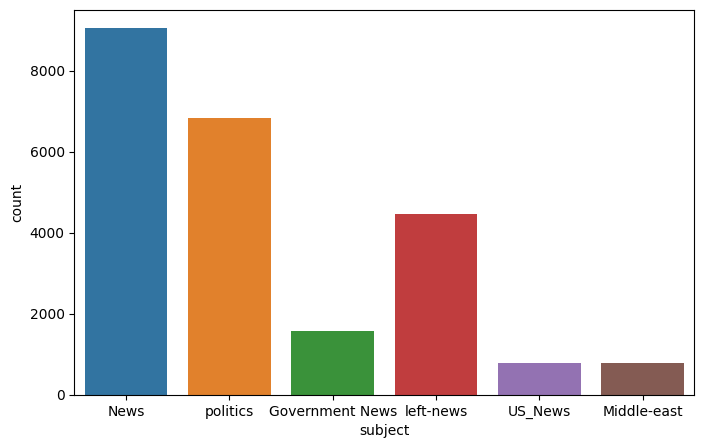

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x="subject", data=fake)
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


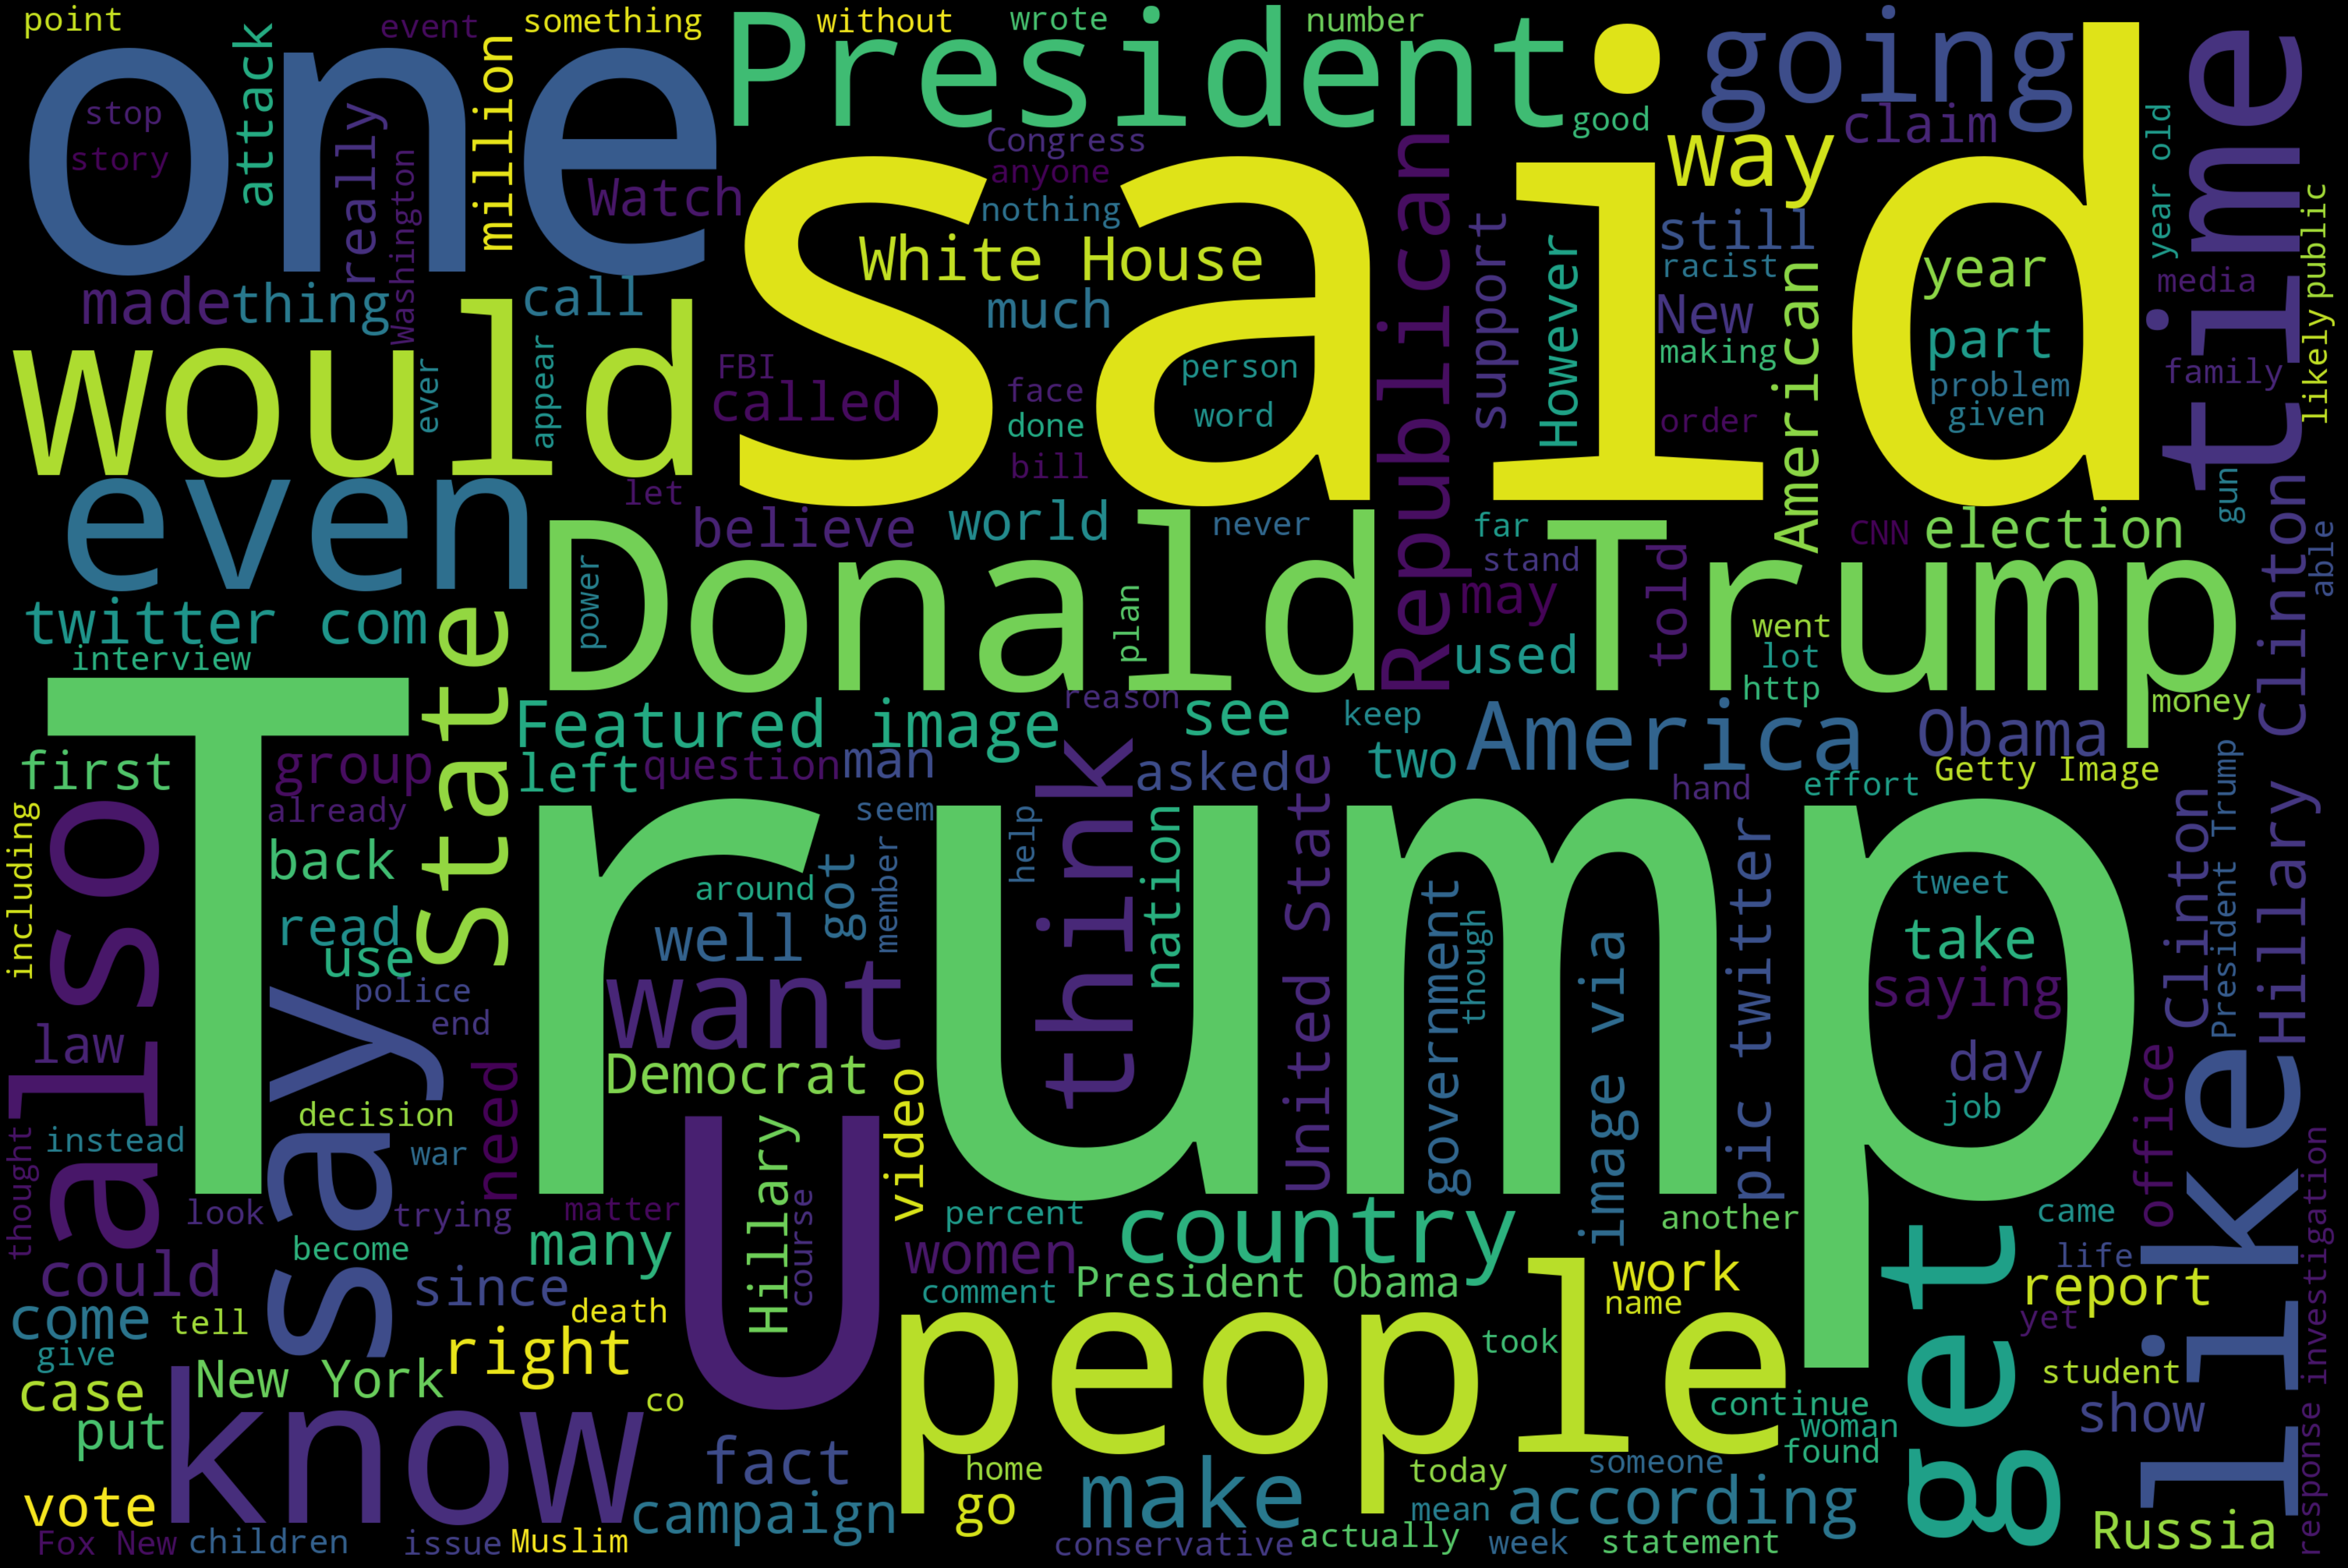

In [ ]:
#Word Cloud
import nltk
nltk.download('stopwords')
text = ''
for news in fake.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (50, 50),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

In [ ]:
real.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

In [ ]:
#First Creating list of index that do not have publication part
unknown_publishers = []
for index,row in enumerate(real.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of piblication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)

In [ ]:
real.iloc[unknown_publishers].text

3488     The White House on Wednesday disclosed a group...
4358     Neil Gorsuch, President Donald Trump’s appoint...
4465     WASHINGTON The clock began running out this we...
5784     Federal appeals court judge Neil Gorsuch, the ...
6660     Republican members of Congress are complaining...
6823     Over the course of the U.S. presidential campa...
7922     After going through a week reminiscent of Napo...
8194     The following timeline charts the origin and s...
8195     Global health officials are racing to better u...
8247     U.S. President Barack Obama visited a street m...
8465     ALGONAC, MICH.—Parker Fox drifted out of the D...
8481     Global health officials are racing to better u...
8482     The following timeline charts the origin and s...
8505     Global health officials are racing to better u...
8506     The following timeline charts the origin and s...
8771     In a speech weighted with America’s complicate...
8970                                                    

In [ ]:
real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [ ]:
#Seperating Publication info, from actual text
publisher = []
tmp_text = []
for index,row in enumerate(real.text.values):
    if index in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)

        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

In [ ]:
#Replace existing text column with new text
#add seperate column for publication info
real["publisher"] = publisher
real["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers

In [ ]:
real.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0   The head of a conservative Republican faction...  politicsNews   
1   Transgender people will be allowed for the fi...  politicsNews   
2   The special counsel investigation of links be...  politicsNews   
3   Trump campaign adviser George Papadopoulos to...  politicsNews   
4   President Donald Trump called on the U.S. Pos...  politicsNews   

                 date                     publisher  
0  December 31, 2017           WASHINGTON (Reuters)  
1  December 29, 2017           WASHINGTON (Reuters)  
2  December 31, 2017           WASHINGTON (Reuters)  
3  December 30, 2017           WASHINGTON (Reuters)  
4  December 29, 2017   SEATTLE/WASHINGTON (Reuters)

In [ ]:
#checking for rows with empty text like row:8970
[index for index,text in enumerate(real.text.values) if str(text).strip() == '']
#seems only one :)

[8970]

In [ ]:
#dropping this record
real = real.drop(8970, axis=0)

In [ ]:
# checking for the same in fake news
empty_fake_index = [index for index,text in enumerate(fake.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_fake_index)}")
fake.iloc[empty_fake_index].tail()

No of empty rows: 630


title text    subject  \
21816  BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...       left-news   
21826  FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...       left-news   
21827  (VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...       left-news   
21857  (VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...       left-news   
21873  (VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...       left-news   

               date  
21816  Apr 27, 2015  
21826  Apr 25, 2015  
21827  Apr 25, 2015  
21857  Apr 14, 2015  
21873  Apr 12, 2015

In [ ]:
#Getting Total Rows
print(f"Total Records:\t{real.shape[0]}")

#Counting by Subjects
for key,count in real.subject.value_counts().iteritems():
  print(f"{key}:\t{count}")

Total Records:	21416
politicsNews:	11271
worldnews:	10145


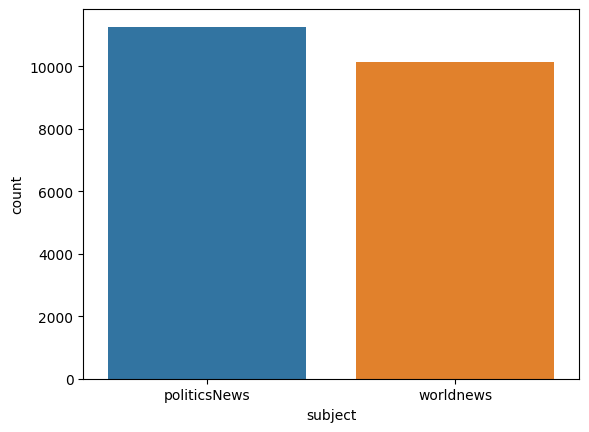

In [ ]:
sns.countplot(x="subject", data=real)
plt.show()

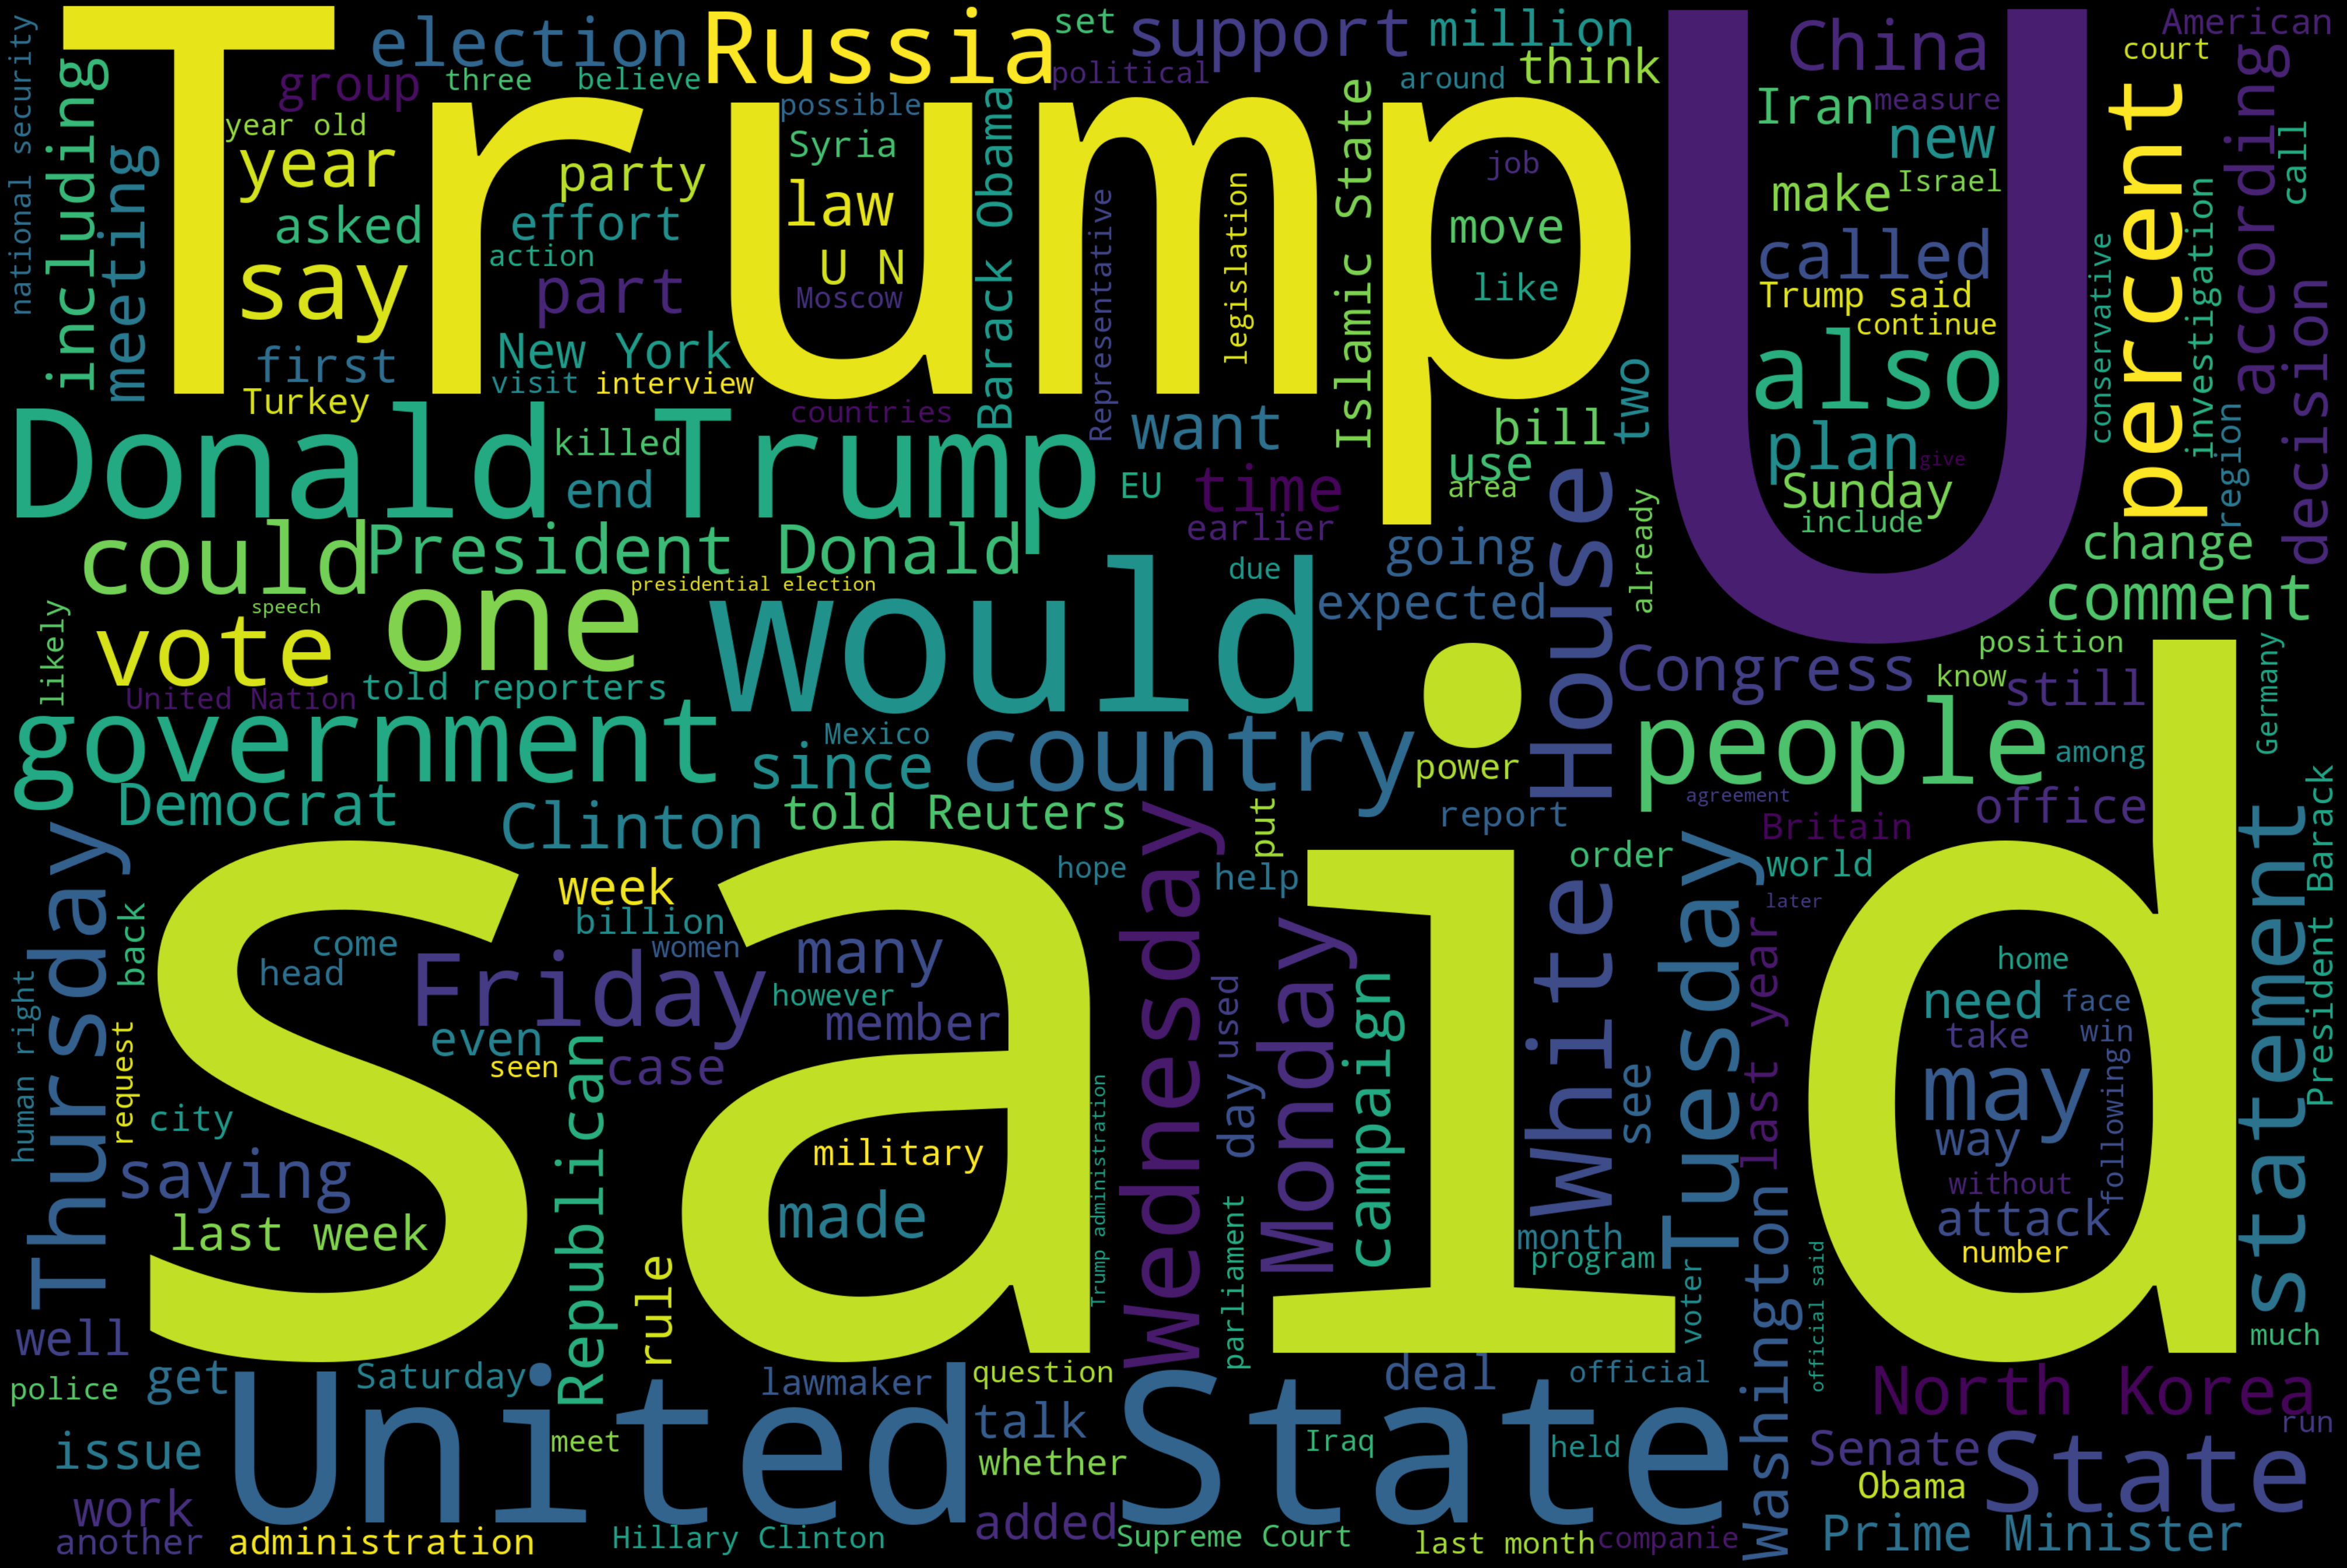

In [ ]:
#WordCloud For Real News
text = ''
for news in real.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

In [ ]:
# Adding class Information
real["class"] = 1
fake["class"] = 0

In [ ]:
#Combining Title and Text
real["text"] = real["title"] + " " + real["text"]
fake["text"] = fake["title"] + " " + fake["text"]

In [ ]:
# Subject is diffrent for real and fake thus dropping it
# Aldo dropping Date, title and Publication Info of real
real = real.drop(["subject", "date","title",  "publisher"], axis=1)
fake = fake.drop(["subject", "date", "title"], axis=1)

In [ ]:
#Combining both into new dataframe
data = real.append(fake, ignore_index=True)
del real, fake

In [ ]:
import nltk
nltk.download('punkt')
y = data["class"].values
#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in data["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import gensim

In [ ]:


#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=EMBEDDING_DIM, window=5, min_count=1)


In [ ]:
#vocab size
vocab_size = len(w2v_model.wv.key_to_index)
print("Vocabulary size: ", vocab_size)



Vocabulary size:  122248


In [ ]:
tokenizer = Tokenizer(num_words=5000)
X = [' '.join([str(word) for word in review]) for review in X]
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)


In [ ]:
#Lets check few word to numerical replesentation
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break

trump -> 1
said -> 2
president -> 3
would -> 4
people -> 5
one -> 6
state -> 7
new -> 8
obama -> 9
also -> 10


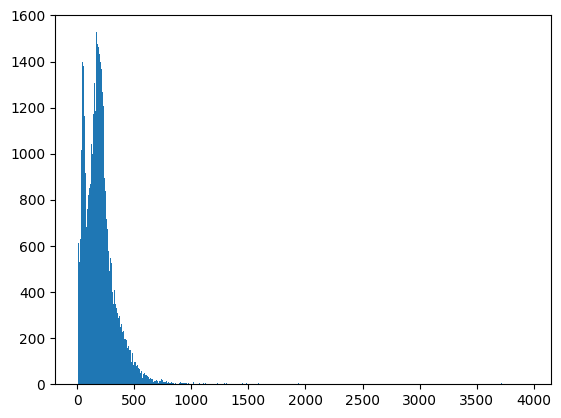

In [ ]:
# For determining size of input...

# Making histogram for no of words in news shows that most news article are under 700 words.
# Lets keep each news small and truncate all news to 700 while tokenizing
plt.hist([len(x) for x in X], bins=500)
plt.show()

In [ ]:
maxlen = 1000
X = pad_sequences(X, padding='post', maxlen=maxlen)


In [ ]:
len(X[0])

1000

In [ ]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 100))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        if word in model.wv:
            weight_matrix[i] = model.wv.get_vector(word)
    return weight_matrix

In [ ]:
embedding_matrix = get_weight_matrix(w2v_model, word_index)

In [ ]:

from keras.optimizers import RMSprop
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, Activation, Flatten
from keras.optimizers import Adam

from keras.layers import Bidirectional

EMBEDDING_DIM=100

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Conv1D(activation='relu', filters=4, kernel_size=4))
model.add(MaxPool1D())
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

del embedding_matrix
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         12179500  
                                                                 
 conv1d (Conv1D)             (None, 997, 4)            1604      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 498, 4)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 128)               68096     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 12,249,329
Trainable params: 69,829
Non-trainable params: 12,179,500
_______________________________________

In [ ]:
def calculate_score(arr):
    if len(arr) <= 1:
        return 0

    score = 0

    for i in range(len(arr) - 1):
        couple_sum = arr[i] + arr[i+1]
        if couple_sum % 2 == 0:
            score += 5

    for i in range(len(arr) - 2):
        triplet_sum = arr[i] + arr[i+1] + arr[i+2]
        triplet_product = arr[i] * arr[i+1] * arr[i+2]
        if triplet_sum % 2 != 0 and triplet_product % 2 == 0:
            score += 10

    return score

def main():
    array_length = int(input("Enter the size of the array: "))
    arr = []
    for i in range(array_length):
        arr.append(int(input("Enter element {}: ".format(i+1))))
    result = calculate_score(arr)
    print("Final score:", result)

if __name__ == "__main__":
    main()


Enter the size of the array: 5
Enter element 1: 19
Enter element 2: 0
Enter element 3: -95
Enter element 4: -93
Enter element 5: -37
Final score: 10


In [ ]:
history= model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1123/1123 [==============================] - 34s 20ms/step - loss: 0.6902 - acc: 0.5245 - val_loss: 0.6906 - val_acc: 0.5171
Epoch 2/10
1123/1123 [==============================] - 23s 21ms/step - loss: 0.6893 - acc: 0.5246 - val_loss: 0.6906 - val_acc: 0.5173
Epoch 3/10
1123/1123 [==============================] - 25s 22ms/step - loss: 0.6893 - acc: 0.5247 - val_loss: 0.6903 - val_acc: 0.5173
Epoch 4/10
1123/1123 [==============================] - 23s 20ms/step - loss: 0.6843 - acc: 0.5272 - val_loss: 0.6947 - val_acc: 0.5173
Epoch 5/10
1123/1123 [==============================] - 23s 21ms/step - loss: 0.5082 - acc: 0.6900 - val_loss: 0.1671 - val_acc: 0.9523
Epoch 6/10
1123/1123 [==============================] - 23s 21ms/step - loss: 0.1167 - acc: 0.9620 - val_loss: 0.0975 - val_acc: 0.9693
Epoch 7/10
1123/1123 [==============================] - 22s 19ms/step - loss: 0.0801 - acc: 0.9743 - val_loss: 0.0896 - val_acc: 0.9736
Epoch 8/10
1123/1123 [==========================

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int")

281/281 [==============================] - 2s 7ms/step


In [ ]:
accuracy_score(y_test, y_pred)
accr_train = model.evaluate(X_train,y_train)
print('Accuracy Train: {}'.format(accr_train[1]*100))
accr_test = model.evaluate(X_test,y_test)
print('Accuracy Test: {}'.format(accr_test[1]*100))

1123/1123 [==============================] - 10s 9ms/step - loss: 0.0717 - acc: 0.9781
Accuracy Train: 97.80605435371399
281/281 [==============================] - 2s 8ms/step - loss: 0.0882 - acc: 0.9717
Accuracy Test: 97.17149138450623


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4644
           1       0.97      0.97      0.97      4336

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980



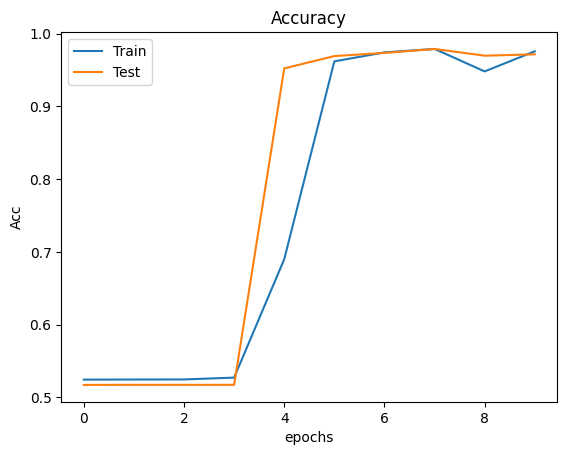

In [ ]:
plt.figure()
plt.plot(history.history["acc"], label = "Train")
plt.plot(history.history["val_acc"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

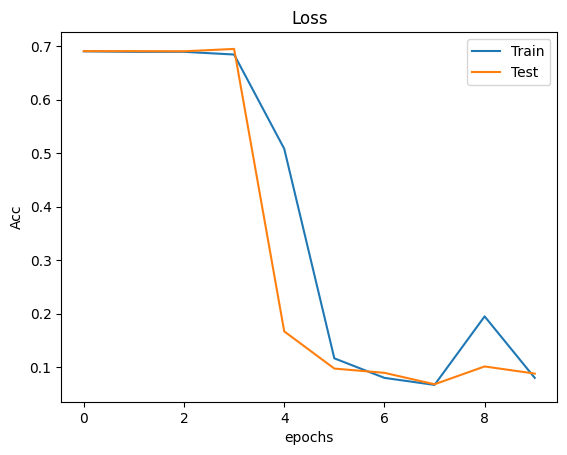

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [ ]:
model.save("Hybrid")